# Titanic Survival Prediction

This workbook is to analyze the data about Titanic survivors information, and use and evaluate logistic regression model and Random Forest which is applying on the dataset.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

train = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/train.csv')
test = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/test.csv')

### 01. Data Exploration

In [2]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
# see the summary of the data

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
# see the missing value
print('missing value on train set')
print(train.isnull().sum())
print("-" * 40)
print('missing value on test set')
print(test.isnull().sum())

missing value on train set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
missing value on test set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### 01.1 Embarking Place

Where the passengers embarked? (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


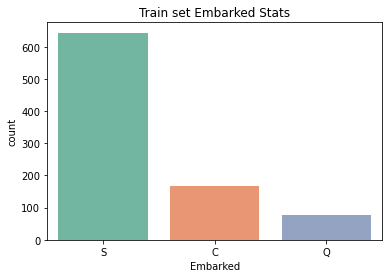

In [6]:
print('Where the passengers embarked? (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train['Embarked'].value_counts())
plt.title('Train set Embarked Stats')
sns.countplot(x='Embarked', data=train, palette='Set2')
plt.show()

C = Cherbourg, Q = Queenstown, S = Southampton


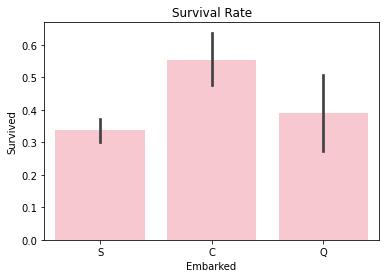

In [7]:
print('C = Cherbourg, Q = Queenstown, S = Southampton')
plt.title('Survival Rate')
sns.barplot('Embarked', 'Survived', data=train, color='pink')
plt.show()

#### 01.2  Survival Rate with Sex

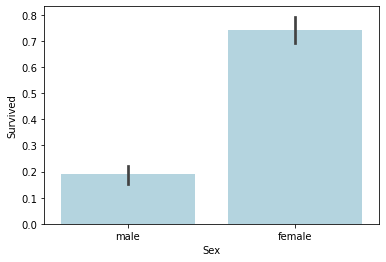

In [8]:
sns.barplot('Sex', 'Survived', data = train, color="lightblue")
plt.show()

#### 01.3  Survival Rate with Ticket Price

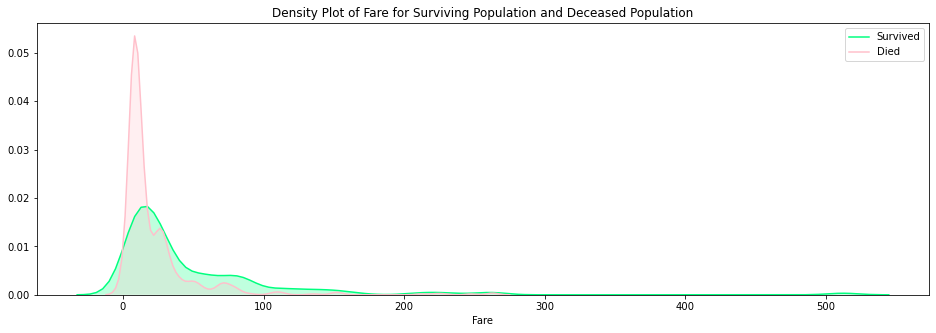

In [9]:
plt.figure(figsize=(16,5))
ax = sns.kdeplot(train["Fare"][train.Survived == 1], color = "springgreen", shade = True)
sns.kdeplot(train["Fare"][train.Survived == 0], color = "pink", shade = True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel = 'Fare')
plt.show()

#### 01.4 Survival Rate with Age

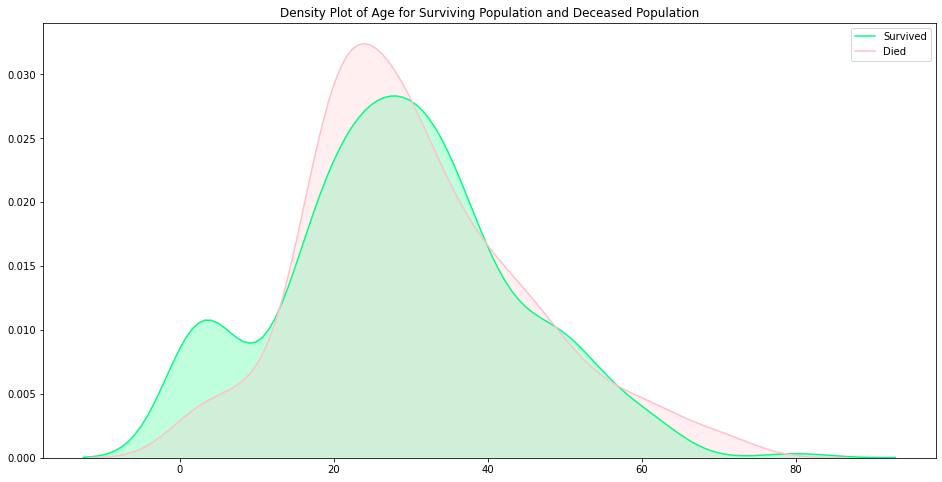

In [10]:
plt.figure(figsize=(16,8))
sns.kdeplot(train["Age"][train.Survived == 1], color="springgreen", shade = True)
sns.kdeplot(train["Age"][train.Survived == 0], color = "pink", shade = True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel = 'Age')
plt.show()

### 02. Data Preprocessing 

#### 02.1 Deal with missing value in Age column

In [11]:
test['Survived'] = 2
union_df = train.append(test)
# after append, there will be the duplicate index problem, must reset index here
union_df.reset_index(inplace=True)
union_df.drop(['index','PassengerId'], inplace=True, axis=1)

In [12]:
# the code is from demo code
fill_mean = lambda x: x.fillna(x.mean())
union_df['Age'] = union_df.groupby(['Sex','Pclass'])['Age'].apply(fill_mean)

#### 02.2 Use binary expression to represent Sex

In [13]:

# Transform Sex column to 0(Female) and 1(Male)
# use Mapping function
union_df['Sex'] = union_df['Sex'].map({'male':1, 'female':0})
   
union_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


#### 02.3 Dummy variable coding on Embarked column

In [14]:
# dummy variable on Embarked column

embarked_df = pd.get_dummies(union_df["Embarked"], prefix = 'Embarked')
union_df = pd.concat([union_df, embarked_df], axis = 1)
union_df.drop('Embarked', axis = 1, inplace = True)

In [15]:
test = union_df[union_df['Survived'] == 2]

train = union_df[union_df['Survived'] != 2]
union_df = 0

In [16]:
# Check the missing value
print('missing value on train set')
print(train.isnull().sum())
print("-" * 40)
print('missing value on test set')
print(test.isnull().sum())

missing value on train set
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64
----------------------------------------
missing value on test set
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin         327
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


### 03. Logistic Regression Model

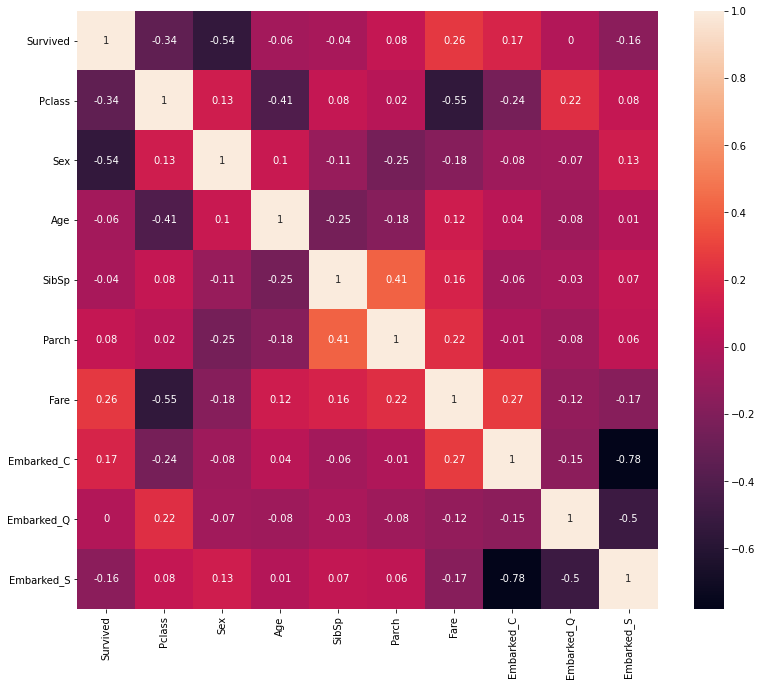

In [17]:
# Correlation Matrix

corr_matrix = train.corr().round(2)
plt.figure(figsize=(13,11))
sns.heatmap(data = corr_matrix, annot=True)

#### 03.1 Train the model

In [18]:
# Only keep preditors in the train and test table
Pred_cols = ['Pclass','Sex','Age','SibSp','Parch','Embarked_S','Embarked_C','Embarked_Q']
result_cols = ['Survived']

x_train = train[Pred_cols]
x_test = test[Pred_cols]
y_train = train[result_cols]
x_train.head()


,Pclass,Sex,Age,SibSp,Parch,Embarked_S,Embarked_C,Embarked_Q
0,3,1,22.0,1,0,1,0,0
1,1,0,38.0,1,0,0,1,0
2,3,0,26.0,0,0,1,0,0
3,1,0,35.0,1,0,1,0,0
4,3,1,35.0,0,0,1,0,0


In [19]:
# Train the model, and generate prediction result both on train and test set

logreg = LogisticRegression(C=1.0, tol=1e-6, max_iter= 1000)
logreg.fit(x_train, y_train.values.reshape(-1))
y_pred_on_test = logreg.predict(x_train)
# prediction on test set
y_pred = logreg.predict(x_test)
print(y_pred.sum())
test1 = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/test.csv')
test1['pred_survive'] = y_pred
test1.head(10)

#output

158


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pred_survive
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


#### 03.2 AUC, ROC, Confusion Matrix

All evaluations are on train set

In [20]:
print('Accuracy score on Train set: ')
print(logreg.score(x_train, y_train))

Accuracy score on Train set: 
0.8069584736251403


In [21]:
# Confusion Matrix on Train set

cm = pd.DataFrame({
                    'Yes':confusion_matrix(y_train, y_pred_on_test)[:,0],
                    'No': confusion_matrix(y_train, y_pred_on_test)[:,1]
})
s = [['Predicted','Predicted'],['Yes','No']]
cm.index = s
v = [['Actual','Actual'],['Yes','No']]
cm.columns = v
cm

Actual     
                 Yes   No
Predicted Yes    475   74
          No      98  244

AUC is:
0.8577131200801031


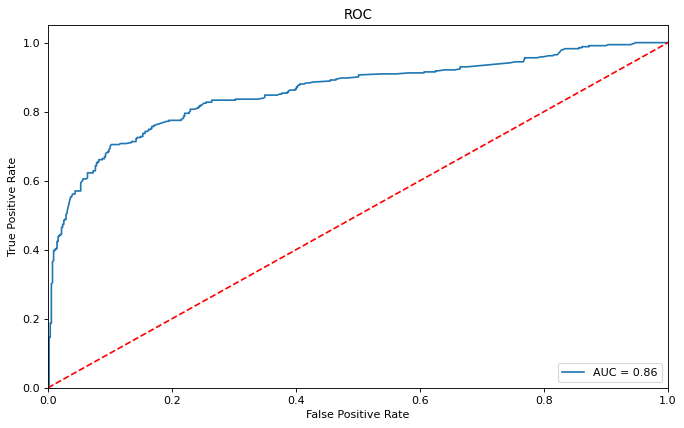

In [22]:
from sklearn import metrics

fpr, tpr, threshold = roc_curve(y_train, logreg.predict_proba(x_train)[:,1])

# Calculate AUC (Area under curve) and ROC figure of the result
s
auc = metrics.auc(fpr, tpr)
print('AUC is:')
print(auc)
plt.figure(figsize=(10, 6), dpi=80)
plt.title('ROC')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 04. Random Forest

Apply random forest on Titanic

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [24]:
def param_eva(a, b):
    rtree = RandomForestClassifier(n_estimators = a, max_depth = b, random_state = 0)
    scores = cross_val_score(estimator = rtree, X = x_train, y = y_train.values.reshape(-1), cv = 6, scoring = 'accuracy')
    #print(scores)
    #print('Average Scores: %2.3f' % scores.mean())
    return scores.mean()

In [25]:
s = param_eva(10,15)
s

0.7811611947517988

#### 04.1 Parameter Evaluation

In [26]:
# Parameter Evaluation
score = 0
for i in range(5,30):
    for j in range(5,30):
        s = param_eva(i,j)
        if s >= score:
            score = s
            est_opt = i
            dep_opt = j

print('Best Estimators (Number of tree): %2.1f' % est_opt)
print('Best max_depth: %2.1f' % dep_opt)


Best Estimators (Number of tree): 19.0
Best max_depth: 5.0


In [27]:
print('Best score with estimator = 19 and max_depth is 15: %2.3f' % score)

Best score with estimator = 19 and max_depth is 15: 0.825


#### 04.2 Train the model

In [28]:
rtree = RandomForestClassifier(n_estimators = 19, max_depth = 5, random_state = 0)
rtree.fit(x_train, y_train.values.reshape(-1))
y_preds = rtree.predict(x_test)
y_preds.sum()

129

In [29]:
# see the probability
y_pred_prob = rtree.predict_proba(x_test).round(2)[:,1]
y_pred_prob

array([0.14, 0.4 , 0.2 , 0.12, 0.45, 0.19, 0.37, 0.3 , 0.62, 0.11, 0.12,
       0.27, 0.84, 0.24, 0.79, 0.84, 0.28, 0.28, 0.44, 0.57, 0.49, 0.49,
       0.81, 0.52, 0.9 , 0.13, 0.87, 0.28, 0.27, 0.26, 0.24, 0.18, 0.45,
       0.42, 0.51, 0.28, 0.45, 0.45, 0.12, 0.12, 0.23, 0.27, 0.11, 0.8 ,
       0.79, 0.12, 0.37, 0.14, 0.87, 0.51, 0.4 , 0.26, 0.8 , 0.81, 0.26,
       0.09, 0.11, 0.12, 0.14, 0.9 , 0.13, 0.17, 0.13, 0.71, 0.67, 0.8 ,
       0.69, 0.27, 0.45, 0.64, 0.58, 0.13, 0.46, 0.45, 0.9 , 0.45, 0.12,
       0.8 , 0.17, 0.58, 0.62, 0.35, 0.27, 0.12, 0.28, 0.24, 0.41, 0.45,
       0.71, 0.72, 0.43, 0.12, 0.77, 0.12, 0.45, 0.12, 0.75, 0.12, 0.45,
       0.11, 0.9 , 0.24, 0.14, 0.12, 0.61, 0.12, 0.29, 0.14, 0.12, 0.17,
       0.26, 0.71, 0.9 , 0.69, 0.76, 0.3 , 0.19, 0.57, 0.45, 0.79, 0.75,
       0.17, 0.9 , 0.12, 0.14, 0.48, 0.13, 0.8 , 0.18, 0.12, 0.12, 0.36,
       0.36, 0.24, 0.11, 0.12, 0.19, 0.17, 0.45, 0.13, 0.17, 0.86, 0.51,
       0.17, 0.27, 0.31, 0.27, 0.13, 0.27, 0.3 , 0.

In [30]:
# This score is the randomforest mean accuracy score, little different to the cross_val score
print('Accuracy is: %2.3f' % rtree.score(x_train, y_train.values.reshape(-1)))


Accuracy is: 0.846


In [31]:
test2 = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/test.csv')
test2['pred_survive'] = y_preds
test2['pred_survive'].sum()
test2.head(10)
#output

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pred_survive
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0
